In [7]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import json
import random

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [9]:
imagenet_transform = transforms.Compose([
    # crop random 224 x 224 subsection of image
    transforms.RandomResizedCrop(224),
    # convert PIL to (C x H x W) tensor and normalize values
    transforms.ToTensor(),
])

label_to_one_hot_transform = transforms.Lambda(lambda x: nn.functional.one_hot(torch.tensor([x]), num_classes=1000).type(dtype=torch.FloatTensor).squeeze())

In [10]:
batch_size = 65
epochs = 35
learning_rate = 0.1

In [11]:
root_of_train = "/home/charles/Remote-Dev/Datasets/ImageNet/Data/train"
root_of_test = "/home/charles/Remote-Dev/Datasets/ImageNet/Data/test"

train_dataset = datasets.ImageFolder(
    root=root_of_train,
    transform=imagenet_transform,
    target_transform=label_to_one_hot_transform
)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)

test_dataset = datasets.ImageFolder(
    root=root_of_test,
    transform=imagenet_transform,
    target_transform=label_to_one_hot_transform
)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

In [12]:
with open("/home/charles/Remote-Dev/ResNet18/id2class.json", "r") as id2class:
    folder2info = json.load(id2class)
    class2name = {folder2info[folder][1]:folder2info[folder][0] for folder in folder2info}

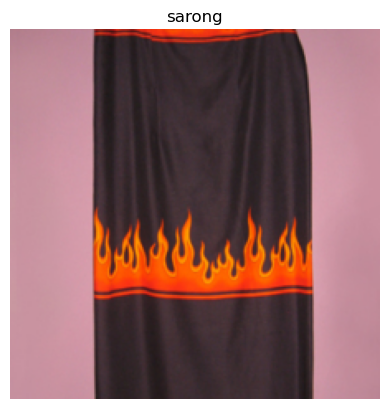

In [13]:
random_idx = random.randint(0, len(train_dataset) - 1)
img, one_hot_pred = train_dataset[random_idx]
label = torch.argmax(one_hot_pred).item()
img_arr = np.transpose(np.asarray(img.cpu()), axes=(1, 2, 0))

plt.title(class2name[label])
plt.imshow(img_arr)
plt.axis("off")
plt.show()

In [14]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2)
        nn.init.kaiming_uniform_(self.conv1.weight)

        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv2_1[0].weight)
        nn.init.kaiming_uniform_(self.conv2_1[3].weight)

        self.conv2_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv2_2[0].weight)
        nn.init.kaiming_uniform_(self.conv2_2[3].weight)

        self.conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv3_1[0].weight)
        nn.init.kaiming_uniform_(self.conv3_1[3].weight)

        self.transition_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        nn.init.kaiming_uniform_(self.transition_conv3.weight)

        self.conv3_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv3_2[0].weight)
        nn.init.kaiming_uniform_(self.conv3_2[3].weight)

        self.conv4_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv4_1[0].weight)
        nn.init.kaiming_uniform_(self.conv4_1[3].weight)

        self.transition_conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2)
        nn.init.kaiming_uniform_(self.transition_conv4.weight)

        self.conv4_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv4_2[0].weight)
        nn.init.kaiming_uniform_(self.conv4_2[3].weight)

        self.conv5_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
        )
        nn.init.kaiming_uniform_(self.conv5_1[0].weight)
        nn.init.kaiming_uniform_(self.conv5_1[3].weight)

        self.transition_conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2)
        nn.init.kaiming_uniform_(self.transition_conv5.weight)

        self.conv5_2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
        ) 
        nn.init.kaiming_uniform_(self.conv5_2[0].weight)
        nn.init.kaiming_uniform_(self.conv5_2[3].weight)

        self.avg_pool = nn.AvgPool2d(kernel_size=3, stride=1)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(in_features=4608, out_features=1000, bias=True)
        nn.init.kaiming_uniform_(self.fc.weight)

    
    def forward(self, X):
        conv1 = self.conv1(X)

        max_pool = self.max_pool(conv1)

        conv2_1 = self.conv2_1(max_pool)

        conv2_2 = self.conv2_2(conv2_1 + max_pool)

        conv3_1 = self.conv3_1(conv2_2 + conv2_1)

        conv3_2 = self.conv3_2(conv3_1 + self.transition_conv3(conv2_2))

        conv4_1 = self.conv4_1(conv3_2 + conv3_1)

        conv4_2 = self.conv4_2(conv4_1 + self.transition_conv4(conv3_2))

        conv5_1 = self.conv5_1(conv4_2 + conv4_1)

        conv5_2 = self.conv5_2(conv5_1 + self.transition_conv5(conv4_2))

        avg_pool = self.avg_pool(conv5_2)
        
        logits = self.flatten(avg_pool)

        logits = self.fc(logits)

        pred = nn.Softmax(dim=-1)(logits)

        return pred



In [15]:
model = ResNet18()
# print(summary(model, input_size=(batch_size, 3, 224, 224)))

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, lr_decay_metric):
    dataset_size = len(dataloader.dataset)

    model.train()
    for batch_num, (X, y) in enumerate(dataloader):
        pred = model(X)

        loss = loss_fn(pred, y) 
        loss.backward()

        optimizer.step()
        scheduler.step(metrics=lr_decay_metric)
        optimizer.zero_grad()

In [30]:
def test_loop(dataloader, model, loss_fn):
    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, accuracy = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)

            avg_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(dim=-1) == y.argmax(dim=-1)).type(torch.float).item()
    
    avg_loss /= num_batches
    accuracy /= dataset_size

    return avg_loss, accuracy * 100
    


In [ ]:
avg_loss = 1
losses, accuracies = [], []
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, lr_decay_metric=avg_loss)
    avg_loss, accuracy_percent = test_loop(test_dataloader, model, loss_fn)

    losses.append(avg_loss)
    accuracies.append(accuracy_percent)

    epochs = range(1, len(losses) + 1)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axs[0].plot(epochs, losses, marker='o', label="Loss")
    axs[0].xlabel("Epochs")
    axs[0].ylabel("Avg Loss")
    axs[0].title("Loss Over Epochs")
    axs[0].grid(True)

    axs[1].plot(epochs, accuracies, marker="o", label="Accuracy")
    axs[1].xlabel("Epochs")
    axs[1].ylabel("Accuracy")
    axs[1].title("Accuracy Over Epochs")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()